In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

# Task 3: PRelu
For runtime purposes, we reduced the number of neurons per layer to 25 in both the sample and modified network. This naturally reduces the network's predictive power, but makes it much easier to adjust and test various network parameters.

First, we ran the provided sample code to get a base line for our comparison, resulting in the following loss spread over a total of 100 epochs:

Epoch: 0
Mean Train Loss: 5.56e-01
Mean Test Loss:  3.15e-01
Epoch: 10
Mean Train Loss: 1.59e-01
Mean Test Loss:  2.15e-01
Epoch: 20
Mean Train Loss: 1.32e-01
Mean Test Loss:  1.69e-01
Epoch: 30
Mean Train Loss: 1.23e-01
Mean Test Loss:  2.09e-01
Epoch: 40
Mean Train Loss: 1.20e-01
Mean Test Loss:  2.36e-01
Epoch: 50
Mean Train Loss: 1.25e-01
Mean Test Loss:  2.79e-01
Epoch: 60
Mean Train Loss: 1.21e-01
Mean Test Loss:  2.81e-01
Epoch: 70
Mean Train Loss: 1.24e-01
Mean Test Loss:  3.03e-01
Epoch: 80
Mean Train Loss: 1.27e-01
Mean Test Loss:  3.80e-01
Epoch: 90
Mean Train Loss: 1.28e-01
Mean Test Loss:  3.25e-01
Epoch: 100
Mean Train Loss: 1.27e-01
Mean Test Loss:  3.34e-01


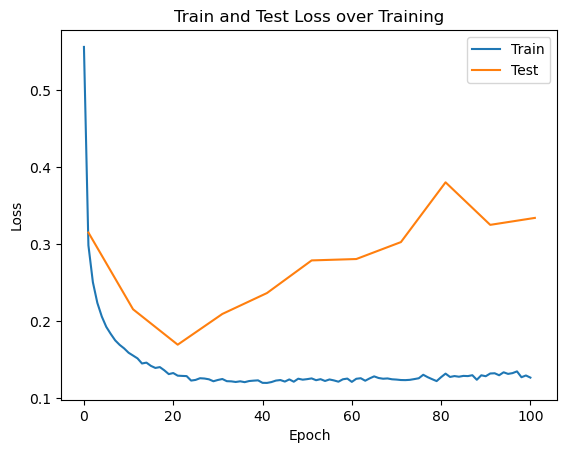

In [2]:
# Sample code
plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax



# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 25))
# hidden layer with 625 neurons
w_h2 = init_weights((25, 25))
# hidden layer with 625 neurons
w_o = init_weights((25, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

As shown in the graph, the network quickly converges on a training mean loss of ~12% after approximately 20 epochs, and barely improves afterwards. On the contrary, the network even starts to severly overfit at the same point, as the test set's mean loss shoots up almost linearly after 20 epochs, from approximately 17% at epoch 20 to 33% after 100 epochs.

For the PRelu implementation, we used the formula suggested in the paper written by Kaiming et al[1], and simply replaced both Relu layers with their respective PRelu counterparts.
For the initial weights, we tested multiple variants, including the initializations used by the original authors (`a = 0.25` and a gaussian distribution with mean 0), as well as the initialization function already used for the weights.
In our case, the results did not differ significantly between the two randomized alternatives, so we decided to stick with the weight initialization for simplicity.

Furthermore, Kaiming et al use a simple linear (In respect to the gradient) backpropagation for their alpha optimization.
The RMS optimizer already present in the sample code seemed to work fine on our test runs, so we decided to use this optimizer instead.

[1]: [https://arxiv.org/pdf/1502.01852.pdf]

Epoch: 0
Mean Train Loss: 6.47e-01
Mean Test Loss:  2.93e-01
Epoch: 10
Mean Train Loss: 1.45e-01
Mean Test Loss:  1.67e-01
Epoch: 20
Mean Train Loss: 1.10e-01
Mean Test Loss:  2.00e-01
Epoch: 30
Mean Train Loss: 9.05e-02
Mean Test Loss:  1.85e-01
Epoch: 40
Mean Train Loss: 7.95e-02
Mean Test Loss:  2.02e-01
Epoch: 50
Mean Train Loss: 7.13e-02
Mean Test Loss:  2.05e-01
Epoch: 60
Mean Train Loss: 6.38e-02
Mean Test Loss:  2.17e-01
Epoch: 70
Mean Train Loss: 5.56e-02
Mean Test Loss:  2.67e-01
Epoch: 80
Mean Train Loss: 5.54e-02
Mean Test Loss:  2.35e-01
Epoch: 90
Mean Train Loss: 4.99e-02
Mean Test Loss:  2.71e-01
Epoch: 100
Mean Train Loss: 4.85e-02
Mean Test Loss:  2.68e-01


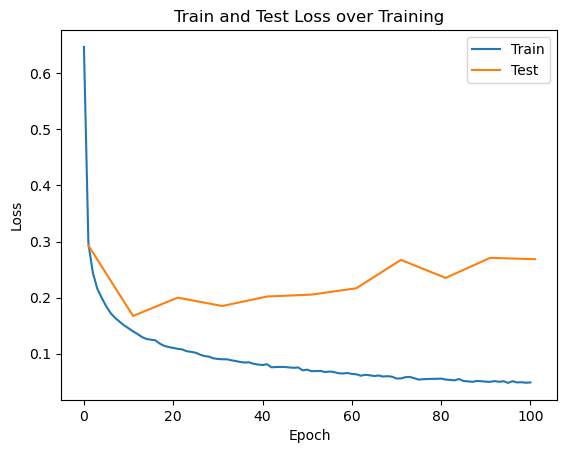

In [4]:
def PRelu(X, a):
    return torch.max(torch.zeros_like(X), X) + a * torch.min(torch.zeros_like(X), X)

plt.rc("figure", dpi=100)

# define the neural network
def Pmodel(x, w_h, a_h, w_h2, a_h2, w_o):
    h = PRelu(x @ w_h, a_h)
    h2 = PRelu(h @ w_h2, a_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights
# input shape is (B, 784)
w_h = init_weights((784, 25))
a_h = init_weights((1, 25))
# hidden layer with 625 neurons
w_h2 = init_weights((25, 25))
a_h2 = init_weights((1, 25))
# hidden layer with 625 neurons
w_o = init_weights((25, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o, a_h, a_h2])
# prelu_optimizer = PReluprop(params=[a_h, a_h2])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = Pmodel(x, w_h, a_h, w_h2, a_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()
        # prelu_optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()
        # prelu_optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = Pmodel(x, w_h, a_h, w_h2, a_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The PRelu implementation clearly outperforms the Relu variant shown above in every regard, even with the simplifications explained above.
An implementation closer to the original paper probably only would have resulted in a slightly more noticable difference - as demonstrated in the paper, PRelu really shines for networks with a high number of layers, but less neurons per layer (In comparison to Relu) - it outperforms it even in less deep networks, but the difference seems to be less significant.

There are two major differences between PRelu and Relu: While both seem to converge on the training data in a similar manner, PRelu still has a noticable performance improvement past epoch 20 (Down to a mean train loss of 5%), while Relu stagnates almost entirely.
PRelu also converges significantly faster, reaching a mean training loss of 11% after only 10 epochs, while Relu is still at 16% at this point.

The second, even more significant difference can be found in the overfitting though: Similar to Relu, PRelu starts overfitting the network to the training data between 10 and 20 epochs (As seen in the increase of the mean test loss), but to a significantly lower extent:
The mean test loss in epoch 100 is approximately 27%, while Relu ends up at 33%.
Especially if compared to the mean train loss of PRelu (5%) versus PRelu (13%), these numbers clearly favor PRelu as the more superior activation function in every regard.